Задание №24 

Используя предобученные нейронные сети для задачи классификации изображений, подобрать модель таким образом, чтобы метрики качества были максимальны. Вывести графики обучения. Проанализировать результат. Использовать колбэки для изменения скорости обучения и сохранения лучшей модели. Использовать набор данных с EuroSat

Анализ и план работы: <br>
Загружаем данные из датасета EurSAT <br>
Загружаем предобученную сеть EfficientNet. Изменяем последний слой в соответствии с набором классов EurSAT <br>
Обучаем сеть <br>
Строим графики <br>
Проверяем метрики на тестовом наборе <br>
Делаем выводы

In [1]:
%reset -f 

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import torch.nn as nn
from torchvision import models

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

Загрузка необходимых модулей

In [2]:
dtype = torch.float # speeding up on the GPU
torch.set_num_threads(4)  # limiting thread number

1. CUDA enable (pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118)

In [3]:
print(f'CUDA is available: {torch.cuda.is_available()}')       # True
if torch.cuda.is_available():
    print(f'Device count: {torch.cuda.device_count()}')        # 1
    print(f'Current device #: {torch.cuda.current_device()}')  # 0
    print(f'GPU name: {torch.cuda.get_device_name(0)}') 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

CUDA is available: True
Device count: 1
Current device #: 0
GPU name: NVIDIA GeForce GTX 1660 SUPER
Device: cuda


Трансформация данных и загрузка данных

In [4]:
batch_size = 32

# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Приведение к размеру 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Нормализация как в ImageNet
                         std=[0.229, 0.224, 0.225])
])

# EurSAT data loading
dataset = datasets.EuroSAT(root="./data", download=True, transform=transform)
# Define train/test split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))  # 10% for validation
test_size = len(dataset) - train_size - val_size # 10% for testing

# Randomly split the dataset
train_dataset, tmp_dataset = random_split(dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(tmp_dataset, [val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Classes for EurSAT images
classes = dataset.classes
print(f"Classes: {classes}, total {len(classes)}")

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], total 10


8. Initializing the ResNet model (and loading the previosly saved state if any)

In [5]:
# Загрузка предобученной модели

# model = models.resnet18(pretrained=True)  # Можно заменить на MobileNet, EfficientNet и т.д.
# model = models.mobilenet_v2(pretrained=True)  
model = models.efficientnet_b0(pretrained=True)  

# Замена последнего слоя классификации
num_classes = 10  # Классы EuroSat
# model.fc = nn.Linear(model.fc.in_features, num_classes) # for ResNet18
# model.classifier[1] = nn.Linear(model.last_channel, 10) # for MobileNet
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10) # for EfficientNet

# Настройка оптимизатора и функции потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Decreasing learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

# trying to read the saved checkpoint to restore models state for keeping on the training
try:
    checkpoint = torch.load('checkpoint_efficientnet.pth')
    model.load_state_dict(checkpoint['model_state_dict']) # load model state       
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Переместить параметры оптимизатора на нужное устройство
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    train_loss_values = checkpoint['train_loss_values']
    val_accuracy_values = checkpoint['val_accuracy_values']
    current_epoch = checkpoint['epoch'] 
except:
    current_epoch = 1
    best_val_accuracy = 0
    print('No checkpoint loaded')
    train_loss_values = []
    val_accuracy_values = []
    
# trying to read the saved best model checkpoint to extract the best validation accuracy reached
try:
    checkpoint_best = torch.load('best_model_efficientnet.pth')
    best_val_accuracy =  checkpoint_best['best_val_accuracy']  
except:
    best_val_accuracy = 0    
    print('No best model loaded')
    
# Перемещение на GPU, если доступно
model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Обучение модели

In [6]:
epochs = 20

while current_epoch <= epochs:
    print(f'Epoch [{current_epoch}/{epochs}]')
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    average_loss = running_loss/len(train_loader)
    print(f'Loss: {average_loss}')
    train_loss_values.append(average_loss) # appending new value of average loss
    
   
    model.eval()
    # evaluation on the validation dataset
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    print(f'Validation Accuracy: {val_accuracy:.2f}%')
    val_accuracy_values.append(val_accuracy)
    
    # Keep the best model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy        
        torch.save({'model_state_dict': model.state_dict(),  # model weights
                    'best_val_accuracy' : best_val_accuracy}, 
                   'best_model_efficientnet.pth')
        print(f"New best model saved with accuracy: {best_val_accuracy:.2f}%")   

    # Decreasing the learning rate
    scheduler.step(val_accuracy)
    
    current_epoch += 1

Epoch [16/20]
Loss: 0.014241022797992896
Validation Accuracy: 99.96%
New best model saved with accuracy: 99.96%
Epoch [17/20]
Loss: 0.010436356381324003
Validation Accuracy: 99.74%
Epoch [18/20]
Loss: 0.006750630213861128
Validation Accuracy: 99.85%
Epoch [19/20]
Loss: 0.009011485629838447
Validation Accuracy: 99.74%
Epoch [20/20]
Loss: 0.0054279289900794675
Validation Accuracy: 99.74%


In [7]:
# 10. Save the current state of the model (i.e. checkpoint)

In [8]:
# Save model weights and additional information like optimizer state, epoch, etc.
try:
    torch.save({
        'epoch': current_epoch,
        'model_state_dict': model.state_dict(),  # model weights
        'optimizer_state_dict': optimizer.state_dict(), # optimizer   
        'train_loss_values' : train_loss_values,
        'val_accuracy_values' : val_accuracy_values 
        }, 'checkpoint_efficientnet.pth')
except:
    print('Error. No current model saved')

Графики обучения

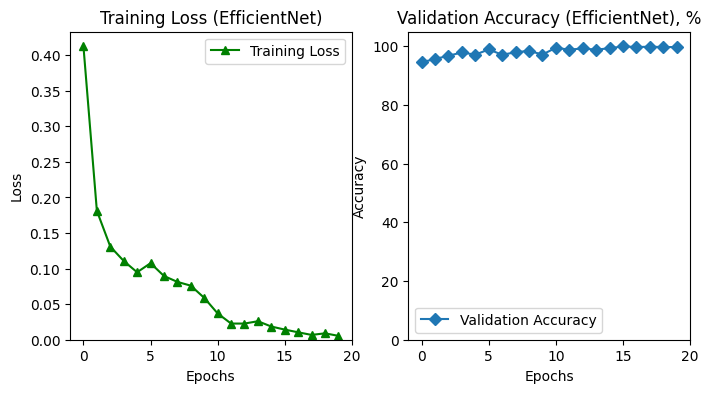

In [9]:
import matplotlib.pyplot as plt

# Learning plots

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_values, 'g-^', label='Training Loss') # 'g^-' - green triangles + solid line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss (EfficientNet)')
plt.legend()
plt.axis([-0.05*epochs, 1.05*epochs-1, 0, 1.05*max(train_loss_values)])

plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracy_values, 'D-', label = 'Validation Accuracy') # 'D-' diamonds + solid line
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy (EfficientNet), %')
plt.legend()
plt.axis([-0.05*epochs, 1.05*epochs-1, 0, 1.05*max(val_accuracy_values)])

plt.show()

Evaluating the model using the Satellite test dataset

In [10]:
model.eval()
# evaluation on the test dataset
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
    
test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')   

Test Accuracy: 99.96%


**Выводы:** <br>
На основе предобученной модели EfficientNet проведена классификация изображения EurSAT <br>
Достигнутая точность классификации на тестовой выборке составила: <br> 
96.93% (за 5 эпох) <br>
97.44% (за 10 эпох) <br>
99.26% (за 15 эпох) <br>
99.96% (за 20 эпох) <br>
В последнем случае на валидационной выборке была точность классификации 99.74%. Валидационная выборка ничем не отличалась от тестовой и в нашем случае никак не участвовала в обучении, использовалась только для контроля метрики в ходе обучения и для сохранения наилучшей текущей модели.
